핸즈온 7장 앙상블 학습과 랜덤 포레스트 p.257- 272 필사


### **[개념 정리+코드 필사]📝**

### **7.5 부스팅**

부스팅: 약한 학습기를 여러 개 연결해 강한 학습기를 만드는 앙상블. 앞의 모델을 보완하며 예측기를 학습시킴. 배깅은 독립적 모델을 학습했다면 부스팅은 모델을 보완하며 학습함

📘 7.5.1 에이다부스트

- 이전 예측기를 보완하면서 새로운 예측기를 만들기 위해, _이전 모델이 과소적합했던(학습하기 어려운) 훈련 샘플의 가중치를 더 높여_ 새 예측기는 샘플에 더 맞춰 학습하도록함.

> 1. 첫번째 분류기로 훈련 세트 훈련, 예측
2. 알고리즘이 잘못 분류한 훈련 샘플의 가중치를 더 높임
3. 업데이트 된 가중치를 사용해 두번째 분류기로 훈련 세트 훈련, 예측
  - 첫번쨰 예측기 학습 후, 가중치가 적용된 에러율로 훈련세트에 대해 계산함. 가중치는 업데이트됨.(잘못 분류된 샘플의 가중치 증가 후, 모든 샘플의 가중치를 정규화함)
  - 예측기 가중치: 예측기가 정확할수록 가중치가 높아짐. 무작위 수준이면 가중치가 0, 그보다도 정확도가 낮으면 가중치는 음수.
4. 반복
5. 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨.

- 잘못 분류한 샘플의 가중치를 절반정도만 높아지게 한게 오른쪽 그래프.(학습률이 절반)
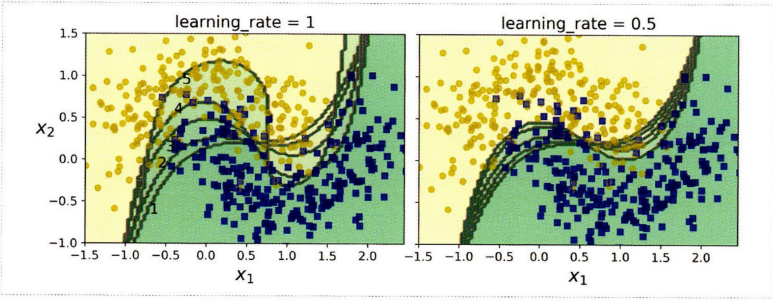

- 연속된 학습 기법으로 경사하강법과 비슷함.
  - 경사하강법은 비용함수를 최소화하기 위해 하나의 예측기의 모델 파라미터를 조정
  - 에이다부스트: 점차 성능이 좋아지도록 앙상블에 예측기를 추가

- 단순히 모든 예측기의 예측을 계산하고 가중치를 더해 가중치 합이 가장 큰 클래스로 예측함.

- 사이킷런의 에이다부스트 다중클래스 버전: 📃AdaBoostClassifier(DecisionTreeClassifier(algorithm="SAMME"))


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# import package
import numpy as np
import os

In [ ]:
#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 7.5.1 에이다부스트
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8



📘 7.5.2 그레이디언트 부스팅

- 마찬가지로 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함. 가중치 업데이트 대신 이전 예측기가 만든 **잔여오차**에 새로운 예측기 학습하는 방식

- 그레이디언트 트리 부스팅(그레이디언트 부스티드 회귀트리): 결정트리기반 예측기로 회귀문제 풀기
  - 1. 결정트리 회귀로 훈련세트 학습
    2. 첫번째 예측기에서 생긴 잔여 오차(y-reg1.predict)에 두번째 결정트리회귀 훈련
    3. 두번째 예측기가 만든 잔여오차(y2-reg2.predict)에 세번째 회귀모델 훈련
    4. 반복
    5. 모든 트리의 예측을 더해 앙상블 예측을 함


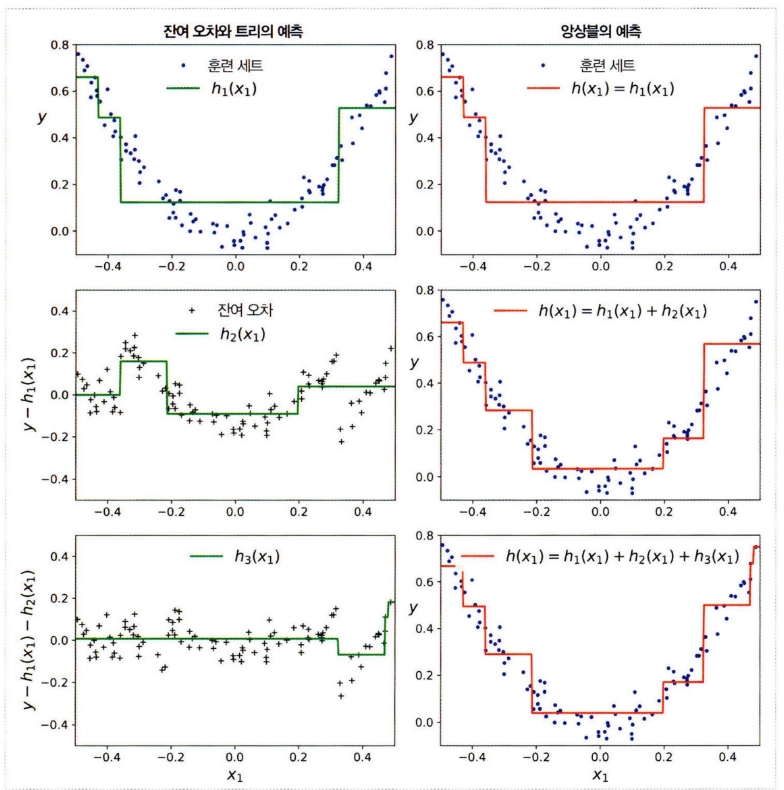

- 트리가 앙상블에 추가될수록 앙상블 예측이 좋아짐
- 사이킷런의 📃GradientBoostingRegressor로 GBRT앙상블 훈련 가능(트리기반과 같은 매개변수 사용)
  - learning_rate: 각 트리의 기여정도 조절. 낮게 설정(**규제방법: 축소**)하면 많은 트리가 필요하고 성능 좋아짐.
  - 최적의 트리 수 찾기:
    - 조기종료기법: warm_start=True / if error_going_up==5: break
    - staged_predict()로 간단히 구현: 훈련의 각 단계에서 앙상블로 만들어진 예측기를 순회하는 반환자를 반환함.
  - subsample=0.25: 훈련샘플 비율 지정(무작위 선택된 25%의 훈련샘플로 학습) 편향증가/분산 감소/훈련속도증가 --> **확률적 그레이디언트 부스팅**

- XGBoost: 최적화된 그레이디언트 부스팅 구현
  - 📃xgboost.XGBRegressor()
  - early_stopping_rounds: 자동조기종료


In [ ]:
# 7.5.2 그레이디언트 부스팅
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 새로운 샘플에 대한 예측: 모든 트리의 예측을 더함
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grbt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
grbt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [ ]:
# grbt 앙상블 훈련, 각 훈련에서 검증 오차 측정해 최적의 트리수를 찾고 최적의 트리 수로 새로운 GRBT앙상블 훈련
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

grbt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
grbt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in grbt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

grbt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
grbt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=23)

In [ ]:
# 조기종료: 연속해서 다섯번 반복동안 검증오차가 향상되지 않으면 훈련중지
grbt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    grbt.n_estimators = n_estimators
    grbt.fit(X_train, y_train)
    y_pred = grbt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [ ]:
# XGBoost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.42092
[1]	validation_0-rmse:0.37889
[2]	validation_0-rmse:0.36342
[3]	validation_0-rmse:0.36143
[4]	validation_0-rmse:0.36483


### **7.6 스태킹**

앙상블의 모든 예측기의 예측을 취합할 때, 함수로 계산하는 것 대신 취합하는 모델을 훈련함. 취합하는 마지막 예측기를 블렌더(메타학습기)라 함.

- 블렌더의 학습: 홀드아웃 세트 사용.
  - 2개의 서브셋(훈련세트): 첫번째 서브셋으로 첫번째 레이어 훈련 > 예측기를 이용해 두번째 서브셋에 대한 예측 > 타깃은 그대로, 앞의 예측값을 입력 특성으로 사용하는 새로운 훈련 세트(3차원)로 블렌더 훈련
  - 3개 이상의 서브셋: 블렌더 여러개 훈련시킬 수 있음. 블렌더만의 레이어를 생성해 새로운 샘플에 대한 예측 수행


- 사이킷런 직접 지원 X, 오픈소스 구현을 사용함

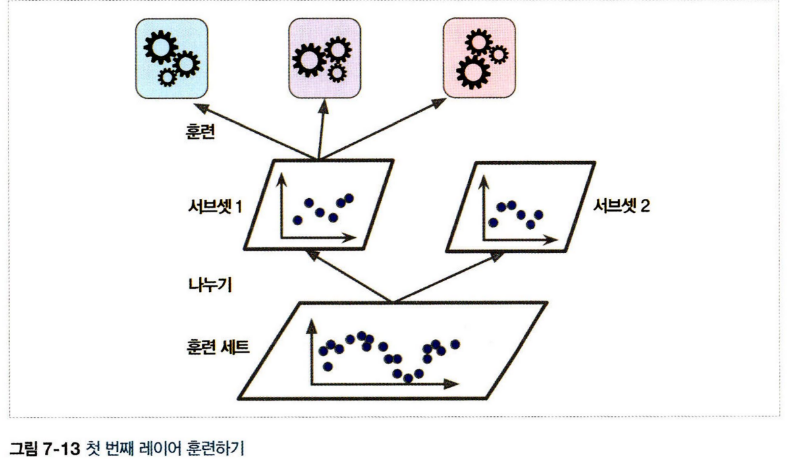

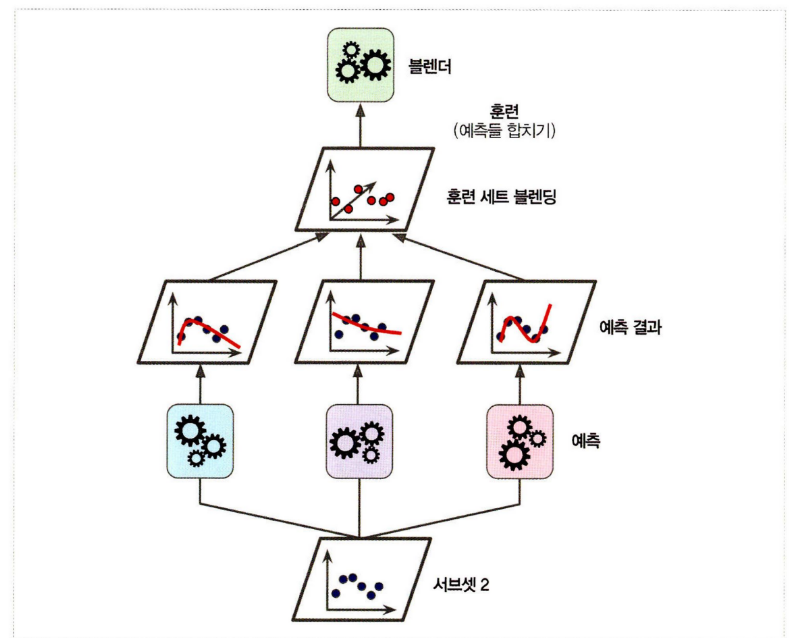